In [2]:
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator

2023-05-13 10:33:42.575116: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-13 10:33:42.619552: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-13 10:33:42.620000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 10:33:43.446276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
df = pd.read_csv('ddb_output.csv')
df.rename(columns={'humidity.S': 'humidity',
                   'temperature.S':'temperature',
                   'timestamp.S':'timestamp'},inplace=True)
df.drop(columns=['Unnamed: 0'],inplace=True)
#df.reset_index(drop=True,inplace=True)
df.sort_values(by='timestamp',inplace=True)
df

,humidity,temperature,timestamp
0,54.00,18.04,2023-04-21 12:36:04.168213
1,54.00,18.13,2023-04-21 12:36:07.120651
2,54.00,18.01,2023-04-21 12:36:10.007948
3,54.00,18.09,2023-04-21 12:36:12.959915
4,52.00,18.08,2023-04-21 15:48:08.632782
...,...,...,...
3041,56.35,21.63,2023-05-10 20:30:04.178828
3042,56.91,21.57,2023-05-10 20:40:04.682990
3043,56.72,21.54,2023-05-10 20:50:04.106947
3044,56.77,21.50,2023-05-10 21:00:04.586745


In [5]:
fig = px.scatter(df, x="timestamp", y=["humidity","temperature"], title='All-time humidity and temperature in the grove!')
fig.show()

In [6]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
go.Scatter(x=df['timestamp'],y=df['temperature'], name="Temperature", mode='markers'),
secondary_y=False,
)

fig.add_trace(
go.Scatter(x=df['timestamp'],y=df['humidity'], name="Humidity", mode='markers'),
secondary_y=True,
)

fig.update_layout(
title_text="Temperature and humidity over time"
)

# Set x-axis title
fig.update_xaxes(title_text="Time")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Temperature</b>", title_font_color='blue', secondary_y=False)
fig.update_yaxes(title_text="<b>Humidity</b>", title_font_color='red', secondary_y=True)

In [7]:
df['date'] = df['timestamp'].map(lambda x: pd.Timestamp(x).date())

In [8]:
df_last_week = df[df['timestamp'] > str(pd.Timestamp('2023-05-1'))]

In [9]:
fig = px.box(df_last_week, x="date", y="temperature")
fig.show()

## Building a forecasting model 

In [10]:
df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity','date'])
df_temp.reset_index(inplace=True,drop=True)

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.Timestamp(x)) 

df_temp['timestamp'] = df_temp['timestamp'].dt.round('5min')
df_temp.head()

,temperature,timestamp
0,17.83,2023-04-28 08:25:00
1,17.85,2023-04-28 08:25:00
2,17.85,2023-04-28 08:30:00
3,17.88,2023-04-28 08:30:00
4,17.88,2023-04-28 09:20:00


In [11]:
px.scatter(df_temp, x='timestamp', y='temperature', title='Temperature from 28 April to May 11th (~12 days)')

### Baseline - persistence forecast 1,2,4 hours in advance

In [12]:
df_temp

,temperature,timestamp
0,17.83,2023-04-28 08:25:00
1,17.85,2023-04-28 08:25:00
2,17.85,2023-04-28 08:30:00
3,17.88,2023-04-28 08:30:00
4,17.88,2023-04-28 09:20:00
...,...,...
2087,21.63,2023-05-10 20:30:00
2088,21.57,2023-05-10 20:40:00
2089,21.54,2023-05-10 20:50:00
2090,21.50,2023-05-10 21:00:00


In [13]:
# Test - to predict temperature 1,2,4 hours in advance

def persistence_n_hours(n):

    timestamps_n_hr = df_temp['timestamp'].apply(lambda x: pd.Timestamp(x) + pd.Timedelta(hours=n))

    df_temp_n_hr_baseline = pd.DataFrame(list(zip(timestamps_n_hr,df_temp['temperature'])))
    df_temp_n_hr_baseline.rename(columns={0:'timestamp', 1:'value'},inplace=True)
    df_temp_n_hr_baseline['type'] = f'persist. {n}hrs'
    df_temp_n_hr_baseline = df_temp_n_hr_baseline[['value', 'timestamp', 'type']]
    df_temp_n_hr_baseline

    return df_temp_n_hr_baseline

persist_1_hr = persistence_n_hours(1)
persist_2_hr = persistence_n_hours(2)
persist_4_hr = persistence_n_hours(4)


In [14]:
df_temp['type'] = 'observation'
df_temp.rename(columns={'temperature':'value'},inplace=True)
df_temp

,value,timestamp,type
0,17.83,2023-04-28 08:25:00,observation
1,17.85,2023-04-28 08:25:00,observation
2,17.85,2023-04-28 08:30:00,observation
3,17.88,2023-04-28 08:30:00,observation
4,17.88,2023-04-28 09:20:00,observation
...,...,...,...
2087,21.63,2023-05-10 20:30:00,observation
2088,21.57,2023-05-10 20:40:00,observation
2089,21.54,2023-05-10 20:50:00,observation
2090,21.50,2023-05-10 21:00:00,observation


In [15]:
df_1_hour_forecast = pd.concat([df_temp, persist_2_hr], axis=0)

df_1_hour_forecast['timestamp'] = df_1_hour_forecast['timestamp'].apply(lambda x: pd.Timestamp(x)) 

df_1_hour_forecast.sort_values(by='timestamp',inplace=True)

df_1_hour_forecast_1_day = df_1_hour_forecast[ df_1_hour_forecast['timestamp'] > str(pd.Timestamp('2023-05-10')) ]

df_1_hour_forecast


,value,timestamp,type
0,17.83,2023-04-28 08:25:00,observation
1,17.85,2023-04-28 08:25:00,observation
2,17.85,2023-04-28 08:30:00,observation
3,17.88,2023-04-28 08:30:00,observation
4,17.88,2023-04-28 09:20:00,observation
...,...,...,...
2087,21.63,2023-05-10 22:30:00,persist. 2hrs
2088,21.57,2023-05-10 22:40:00,persist. 2hrs
2089,21.54,2023-05-10 22:50:00,persist. 2hrs
2090,21.50,2023-05-10 23:00:00,persist. 2hrs


In [16]:

px.scatter(df_1_hour_forecast_1_day, x='timestamp', y='value', color='type', title='Temperature from 28 April to May 11th (~12 days)')

In [17]:
df_1_hour_forecast['value'] = df_1_hour_forecast['value'].astype(float)

In [18]:
# This works but not where there's NaN

persistence_forecast_1_hr = df_1_hour_forecast.pivot_table(values='value', index='timestamp', columns='type').head(-20)
persistence_forecast_1_hr['rel_error'] = persistence_forecast_1_hr['observation'] - persistence_forecast_1_hr['persist. 2hrs']
persistence_forecast_1_hr['abs_error'] = abs(persistence_forecast_1_hr['observation'] - persistence_forecast_1_hr['persist. 2hrs'] )

persistence_forecast_1_hr

persistence_forecast_1_hr_errors = persistence_forecast_1_hr[['rel_error','abs_error']]
persistence_forecast_1_hr_errors.reset_index(inplace=True)

persistence_forecast_1_hr_errors = persistence_forecast_1_hr_errors.melt(id_vars='timestamp')
persistence_forecast_1_hr_errors

px.scatter(persistence_forecast_1_hr_errors, x='timestamp', y='value', color='type', title='Errors from a 1-hr persistence forecast')

In [19]:
persistence_forecast_1_hr_errors

,timestamp,type,value
0,2023-04-28 08:25:00,rel_error,NaN
1,2023-04-28 08:30:00,rel_error,NaN
2,2023-04-28 09:20:00,rel_error,NaN
3,2023-04-28 09:30:00,rel_error,NaN
4,2023-04-28 09:40:00,rel_error,NaN
...,...,...,...
4179,2023-05-10 19:10:00,abs_error,0.03
4180,2023-05-10 19:20:00,abs_error,0.01
4181,2023-05-10 19:30:00,abs_error,0.03
4182,2023-05-10 19:40:00,abs_error,0.04


In [20]:
df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity','date'])
df_temp.reset_index(inplace=True,drop=True)

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.to_datetime(x)) 

df_temp['timestamp'] = df_temp['timestamp'].dt.round('5min')

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.to_datetime(x)) 

df_temp.set_index('timestamp',inplace=True)
df_temp

,temperature
timestamp,
2023-04-28 08:25:00,17.83
2023-04-28 08:25:00,17.85
2023-04-28 08:30:00,17.85
2023-04-28 08:30:00,17.88
2023-04-28 09:20:00,17.88
...,...
2023-05-10 20:30:00,21.63
2023-05-10 20:40:00,21.57
2023-05-10 20:50:00,21.54


In [21]:
df_temp.dropna(inplace=True)

# Some quick code to set this up: https://github.com/nachi-hebbar/Time-Series-Forecasting-LSTM

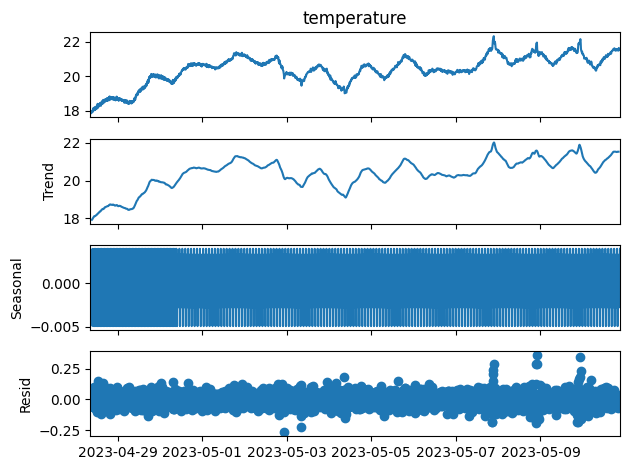

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

results = seasonal_decompose(df_temp['temperature'], period=10)
results.plot()
pyplot.show()

In [23]:
temp_array = df_temp['temperature'][0:100].values
temp_array

array([17.83, 17.85, 17.85, 17.88, 17.88, 17.97, 17.92, 17.99, 17.95,
       18.01, 18.01, 17.97, 17.97, 17.95, 17.97, 18.06, 18.15, 18.06,
       18.11, 18.16, 18.05, 18.11, 18.15, 18.09, 18.08, 18.19, 18.12,
       18.05, 18.12, 18.06, 18.19, 18.16, 18.15, 18.11, 18.22, 18.24,
       18.11, 18.18, 18.15, 18.21, 18.21, 18.22, 18.13, 18.22, 18.39,
       18.22, 18.32, 18.26, 18.21, 18.19, 18.28, 18.28, 18.35, 18.29,
       18.32, 18.39, 18.28, 18.39, 18.34, 18.31, 18.42, 18.39, 18.31,
       18.39, 18.39, 18.38, 18.46, 18.28, 18.4 , 18.42, 18.45, 18.45,
       18.47, 18.5 , 18.52, 18.52, 18.55, 18.39, 18.43, 18.42, 18.53,
       18.53, 18.62, 18.45, 18.47, 18.49, 18.46, 18.52, 18.55, 18.59,
       18.49, 18.55, 18.6 , 18.57, 18.52, 18.59, 18.66, 18.67, 18.6 ,
       18.6 ])

In [24]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [25]:
df_temp

,temperature
timestamp,
2023-04-28 08:25:00,17.83
2023-04-28 08:25:00,17.85
2023-04-28 08:30:00,17.85
2023-04-28 08:30:00,17.88
2023-04-28 09:20:00,17.88
...,...
2023-05-10 20:30:00,21.63
2023-05-10 20:40:00,21.57
2023-05-10 20:50:00,21.54


In [26]:
# Split the data, 70% in training and 30% in test, and not randomly selected since this is a time series

last_train_index = int(np.round(df_temp['temperature'].shape[0]*0.7))

train_data = df_temp.iloc[:last_train_index,]
test_data = df_temp.iloc[last_train_index:,]

# Fit to the train set, then transform the train set and the test set
# TODO: Check, should not fit on test set?

scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(test_data)


In [46]:

train = keras.utils.timeseries_dataset_from_array(
    data=scaled_train[:-3],
    targets=scaled_train[3:],
    sequence_length=3,
    batch_size=1,
    shuffle=True
)

test = keras.utils.timeseries_dataset_from_array(
    data=scaled_test[:-3],
    targets=scaled_test[3:],
    sequence_length=3,
    batch_size=1,
    shuffle=True
)

train_2 = TimeseriesGenerator(scaled_train[:-36], scaled_train[36:], length=36, batch_size=1, shuffle=True)
test_2 = TimeseriesGenerator(scaled_test[:-36], scaled_test[36:], length=36, batch_size=1, shuffle=True)

print(train)
print(test)

print(train_2)
print(test_2)

# for inputs, targets in dummy_dataset:
#     for i in range(inputs.shape[0]):
#         print([float(x) for x in inputs[i]],float(targets[i]))

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [38]:
scaled_train

array([[0.        ],
       [0.00564972],
       [0.00564972],
       ...,
       [0.71468927],
       [0.70903955],
       [0.70621469]])

In [47]:
# An alternative, using TimeseriesGenerator 


for inputs, targets in train_2:
    print('Inputs :', inputs, ', targets: ', targets)

Inputs : [[[0.46610169]
  [0.44067797]
  [0.46045198]
  [0.48305085]
  [0.44915254]
  [0.46892655]
  [0.48587571]
  [0.48870056]
  [0.50282486]
  [0.49717514]
  [0.50564972]
  [0.49435028]
  [0.50282486]
  [0.53672316]
  [0.52259887]
  [0.53107345]
  [0.54237288]
  [0.54237288]
  [0.50564972]
  [0.55084746]
  [0.54237288]
  [0.56497175]
  [0.5819209 ]
  [0.56497175]
  [0.59887006]
  [0.59322034]
  [0.58474576]
  [0.60451977]
  [0.60451977]
  [0.60169492]
  [0.59039548]
  [0.61299435]
  [0.61016949]
  [0.59039548]
  [0.61299435]
  [0.60451977]]] , targets:  [[0.61016949]]
Inputs : [[[0.21751412]
  [0.20338983]
  [0.20903955]
  [0.21751412]
  [0.23446328]
  [0.23446328]
  [0.23446328]
  [0.21751412]
  [0.25423729]
  [0.20903955]
  [0.24293785]
  [0.21468927]
  [0.22316384]
  [0.2259887 ]
  [0.24293785]
  [0.24293785]
  [0.22881356]
  [0.23728814]
  [0.24293785]
  [0.21468927]
  [0.23446328]
  [0.26271186]
  [0.23446328]
  [0.26553672]
  [0.25423729]
  [0.27966102]
  [0.26553672]
  [0.223

In [51]:
from keras import layers

inputs = keras.Input(shape=(36, 1))

x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_2,
                    epochs=5,
                    validation_data=test_2)


Epoch 1/5


2023-05-13 10:42:47.729117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-13 10:42:47.730927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-13 10:42:47.732268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1390/1392 [============================>.] - ETA: 0s - loss: 0.0171 - mae: 0.1014

2023-05-13 10:43:05.236200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-13 10:43:05.417142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-13 10:43:05.418764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

1392/1392 [==============================] - 19s 13ms/step - loss: 0.0171 - mae: 0.1015 - val_loss: 0.0320 - val_mae: 0.1473
Epoch 2/5
1392/1392 [==============================] - 17s 12ms/step - loss: 0.0108 - mae: 0.0857 - val_loss: 0.0459 - val_mae: 0.1823
Epoch 3/5
1392/1392 [==============================] - 18s 13ms/step - loss: 0.0105 - mae: 0.0841 - val_loss: 0.0187 - val_mae: 0.1153
Epoch 4/5
1392/1392 [==============================] - 18s 13ms/step - loss: 0.0104 - mae: 0.0828 - val_loss: 0.0234 - val_mae: 0.1301
Epoch 5/5
1392/1392 [==============================] - 18s 13ms/step - loss: 0.0100 - mae: 0.0821 - val_loss: 0.0202 - val_mae: 0.1205


In [52]:
print(f"Test MAE: {model.evaluate(test)[1]:.2f}")

  1/623 [..............................] - ETA: 5:10 - loss: 0.0637 - mae: 0.2523

2023-05-13 10:44:21.044806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-13 10:44:21.046639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-13 10:44:21.048233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

623/623 [==============================] - 2s 2ms/step - loss: 0.0654 - mae: 0.2525
Test MAE: 0.25


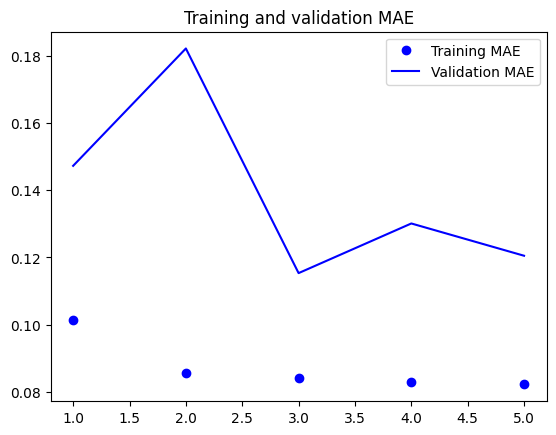

In [53]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [39]:
inputs = keras.Input(shape=(3, 1))

x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)


model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_2,
                    epochs=5)


Epoch 1/5


2023-05-13 10:36:28.174975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-13 10:36:28.177280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-13 10:36:28.179256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1458/1458 [==============================] - 6s 3ms/step - loss: 0.0127 - mae: 0.0505
Epoch 2/5
1458/1458 [==============================] - 5s 3ms/step - loss: 8.3658e-04 - mae: 0.0222
Epoch 3/5
1458/1458 [==============================] - 4s 3ms/step - loss: 9.0838e-04 - mae: 0.0235
Epoch 4/5
1458/1458 [==============================] - 4s 3ms/step - loss: 9.2664e-04 - mae: 0.0233
Epoch 5/5
1458/1458 [==============================] - 4s 3ms/step - loss: 7.9248e-04 - mae: 0.0220


In [33]:
print(f"Test MAE: {model.evaluate(test)[1]:.2f}")

2023-05-13 10:34:48.655120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-13 10:34:48.656750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-13 10:34:48.658010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

623/623 [==============================] - 2s 2ms/step - loss: 0.0016 - mae: 0.0322
Test MAE: 0.03


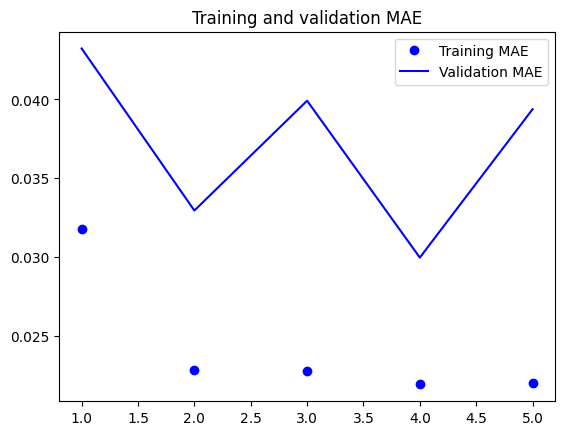

In [36]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Autocorrelation - test using Durbin-Watson test

In [35]:
# Keras - time series forecasting example 

# https://keras.io/examples/adsf/timeseries_weather_forecasting/